In [1]:
# Import necessary libraries
import numpy as np                  
import pandas as pd                 
import matplotlib.pyplot as plt     
from sklearn.preprocessing import OneHotEncoder 

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
def preprocess_dataset(betting_data_dfs):
    # Replace 'NR' (Not Ranked) with NaN in 'WRank' and 'LRank' columns
    betting_data_dfs['WRank'].replace('NR', np.nan, inplace=True)
    betting_data_dfs['LRank'].replace('NR', np.nan, inplace=True)
    
    # Convert 'WRank' and 'LRank' columns to numeric, forcing errors to NaN
    betting_data_dfs['WRank'] = pd.to_numeric(betting_data_dfs['WRank'], errors='coerce')
    betting_data_dfs['LRank'] = pd.to_numeric(betting_data_dfs['LRank'], errors='coerce')

    # Fill NaN values in 'WRank' and 'LRank' with 100000 and convert to float
    betting_data_dfs['WRank'] = betting_data_dfs['WRank'].fillna(100000).astype(float)
    betting_data_dfs['LRank'] = betting_data_dfs['LRank'].fillna(100000).astype(float)

    # Create a column indicating if the higher-ranked player won (1 if true, 0 if false)
    betting_data_dfs['higher_rank_won'] = (betting_data_dfs['WRank'] < betting_data_dfs['LRank']).astype(int)

    # Define the essential columns to keep in the dataframe
    essential_columns = [ 'Date', 'WRank', 'LRank', 'Surface', 'higher_rank_won', 'Winner', 'Loser']

    # Filter the dataframe to keep only the essential columns
    betting_data_filtered = betting_data_dfs[essential_columns]

    # Return the preprocessed dataframe
    return betting_data_filtered

In [3]:
def update_elo(winner_elo, loser_elo, K, surface_factors, surface):
    
    adjusted_k = K * surface_factors[surface]

    # Calculate expected score for the winner
    expected_winner = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    
    # Calculate the change in Elo ratings for the winner
    elo_change_winner = adjusted_k * (1 - expected_winner)
    
    # Calculate the change in Elo ratings for the loser
    elo_change_loser = adjusted_k * (expected_winner - 1)

    # Update the Elo ratings
    updated_winner_elo = winner_elo + elo_change_winner
    updated_loser_elo = loser_elo + elo_change_loser

    # Return the updated Elo ratings and the expected score for the winner
    return (updated_winner_elo, updated_loser_elo, expected_winner)

In [4]:
def calculate_elo_with_k_and_surface(betting_data_dfs_preprocessed, k, surface_factors):
    """
    Calculate Elo ratings for players with a constant K-factor, considering different playing surfaces.

    """
    # Extract unique player IDs from the 'Winner' and 'Loser' columns
    players_ids = pd.concat([betting_data_dfs_preprocessed['Winner'], betting_data_dfs_preprocessed['Loser']]).unique()
    
    # Initialize Elo scores for each player on different surfaces
    surfaces = betting_data_dfs_preprocessed['Surface'].unique()
    elo_scores_constant_k = {player: {surface: 1500 for surface in surfaces} for player in players_ids}

    # Iterate over each match in the DataFrame
    for i in range(len(betting_data_dfs_preprocessed)):
        # Extract the current match details
        tennis_match_row = betting_data_dfs_preprocessed.iloc[i]
        winner_id = tennis_match_row['Winner']
        loser_id = tennis_match_row['Loser']
        surface = tennis_match_row['Surface']
        higher_ranked_wins = tennis_match_row['higher_rank_won']

        # Retrieve current Elo scores for both winner and loser on the specific surface
        winner_elo_before = elo_scores_constant_k[winner_id][surface]
        loser_elo_before = elo_scores_constant_k[loser_id][surface]

        # Update Elo ratings using the constant K-factor
        winner_elo_after, loser_elo_after, prob_winner = update_elo(
            winner_elo_before, loser_elo_before, k, surface_factors, surface)

        # Update the Elo scores in the dictionary
        elo_scores_constant_k[winner_id][surface] = winner_elo_after
        elo_scores_constant_k[loser_id][surface] = loser_elo_after

        # Store pre- and post-match Elo scores in the DataFrame
        betting_data_dfs_preprocessed.at[i, 'winner_elo_before'] = winner_elo_before
        betting_data_dfs_preprocessed.at[i, 'winner_elo_after'] = winner_elo_after
        betting_data_dfs_preprocessed.at[i, 'loser_elo_before'] = loser_elo_before
        betting_data_dfs_preprocessed.at[i, 'loser_elo_after'] = loser_elo_after

        # Calculate the probability of the winner winning
        prob_winner = 1 / (1 + 10 ** ((loser_elo_before - winner_elo_before) / 400))
        betting_data_dfs_preprocessed.at[i, 'prob_winner'] = prob_winner

        # Determine and store match outcomes based on higher-ranked win probabilities
        if tennis_match_row['higher_rank_won'] == 1:
            betting_data_dfs_preprocessed.at[i, 'match_outcome'] = int(prob_winner > 0.5)
            betting_data_dfs_preprocessed.at[i, 'prob_high_ranked'] = prob_winner
        else:
            betting_data_dfs_preprocessed.at[i, 'match_outcome'] = int((1 - prob_winner) > 0.5)
            betting_data_dfs_preprocessed.at[i, 'prob_high_ranked'] = 1 - prob_winner

In [5]:
def accuracy(actual, predictions):
    # Calculate the mean of correct predictions
    logr_accuracy_all_predictors = np.round(np.mean(actual == predictions),4)
    return logr_accuracy_all_predictors

def calibration(actual, predictions):
    # Calculate the ratio of the sum of predictions to the sum of actual values
    return np.round((np.sum(predictions) / np.sum(actual)), 4)

def logloss(actual, predictions):
    epsilon = 1e-15  # Small constant to prevent division by zero
    # Clip predictions to avoid log of zero. Values are clipped to the range [epsilon, 1-epsilon]
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    
    
    logr_logloss_all_predictors = -(1 / len(actual)) * np.sum(
        actual * np.log(predictions) + (1 - actual) * np.log(1 - predictions))
    return np.round(logr_logloss_all_predictors, 4)

In [6]:
# Evaluating predictions using accuracy, calibration and logloss
def evaluate_predictions(actual_outcomes, binary_predictions, probability_predictions):
    accuracy_result = accuracy(actual_outcomes, binary_predictions)
    
    calibration_result = calibration(actual_outcomes, probability_predictions)
    
    logloss_result = logloss(actual_outcomes, probability_predictions)
    
    return accuracy_result, calibration_result, logloss_result

In [7]:
# Initialize a dictionary to store dataframes for each year
betting_data_dfs = {}

In [8]:
# Loop through each year from 2005 to 2019
for current_year in range(2005, 2020): 
    # Determine the file extension based on the year
    file_extension = 'xls' if current_year < 2013 else 'xlsx'
    
    # Construct the file path using the determined file extension
    file_path = f"Betting_Odds_Tennis/{current_year}.{file_extension}"
    
    # Read the Excel file and store it in the dictionary with the year as the key
    betting_data_dfs[current_year] = pd.read_excel(file_path)

In [9]:
betting_data_dfs[2019]

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
0,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Dimitrov G.,...,0.0,Completed,1.36,3.00,1.36,3.37,1.42,3.60,1.35,3.18
1,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Raonic M.,...,0.0,Completed,1.18,4.50,1.23,4.68,1.27,4.84,1.22,4.26
2,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Kecmanovic M.,...,0.0,Completed,1.57,2.25,1.67,2.32,1.71,2.40,1.63,2.28
3,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Millman J.,...,1.0,Completed,1.40,2.75,1.41,3.13,1.45,3.20,1.40,2.95
4,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Uchiyama Y.,...,0.0,Completed,2.62,1.44,2.73,1.51,3.26,1.53,2.69,1.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Nadal R.,...,1.0,Completed,1.44,2.75,1.39,3.26,1.48,3.30,1.41,2.93
2606,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Zverev A.,...,0.0,Completed,1.90,1.90,2.14,1.79,2.24,2.06,1.92,1.90
2607,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Tsitsipas S.,...,0.0,Completed,3.50,1.30,3.75,1.33,3.75,1.40,3.39,1.33
2608,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Thiem D.,...,0.0,Completed,1.80,2.00,1.84,2.10,1.87,2.20,1.78,2.06


In [10]:
# Combine DataFrames from all years into a single DataFrame, reindexing rows.
betting_data_dfs = pd.concat(betting_data_dfs.values(), ignore_index = True)

In [11]:
# Display a summary of the DataFrame to understand its structure and data types
betting_data_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40390 entries, 0 to 40389
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         40390 non-null  int64         
 1   Location    40390 non-null  object        
 2   Tournament  40390 non-null  object        
 3   Date        40390 non-null  datetime64[ns]
 4   Series      40390 non-null  object        
 5   Court       40390 non-null  object        
 6   Surface     40390 non-null  object        
 7   Round       40390 non-null  object        
 8   Best of     40390 non-null  int64         
 9   Winner      40390 non-null  object        
 10  Loser       40390 non-null  object        
 11  WRank       40375 non-null  float64       
 12  LRank       40303 non-null  float64       
 13  WPts        38701 non-null  float64       
 14  LPts        38631 non-null  float64       
 15  W1          40155 non-null  float64       
 16  L1          40157 non-

In [12]:
# Generate descriptive statistics for numerical columns in the DataFrame
betting_data_dfs.describe()

,ATP,Best of,WRank,LRank,WPts,LPts,W1,L1,W4,L4,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
count,40390.000000,40390.000000,40375.000000,40303.000000,38701.000000,38631.000000,40155.000000,40157.000000,3647.000000,3647.000000,...,10671.000000,10671.000000,28131.000000,28142.000000,15572.000000,15579.000000,25354.000000,25354.000000,25354.000000,25354.000000
mean,32.974944,3.378311,57.801536,90.384860,1828.537195,1054.728379,5.801992,4.075155,5.783384,3.865643,...,1.815867,3.542479,1.810226,3.451461,1.796538,3.557943,1.998610,7.847864,1.838168,3.547658
std,18.006138,0.783274,72.735132,115.423997,2278.996487,1212.422674,1.232787,1.841617,1.262227,1.903181,...,0.996238,3.646316,1.031691,3.075889,1.004273,3.272510,1.582432,376.246830,1.089277,3.227770
min,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.010000,1.020000,1.000000,1.000000,1.000000,1.010000,1.010000,1.010000,1.010000,1.010000
25%,19.000000,3.000000,16.000000,34.000000,645.000000,502.000000,6.000000,3.000000,6.000000,2.000000,...,1.240000,1.750000,1.250000,1.730000,1.220000,1.730000,1.300000,1.840000,1.250000,1.740000
50%,33.000000,3.000000,40.000000,64.000000,1010.000000,745.000000,6.000000,4.000000,6.000000,4.000000,...,1.500000,2.500000,1.500000,2.500000,1.500000,2.630000,1.580000,2.750000,1.510000,2.530000
75%,49.000000,3.000000,75.000000,102.000000,1890.000000,1150.000000,6.000000,6.000000,6.000000,6.000000,...,2.030000,3.850000,2.000000,4.000000,2.000000,4.000000,2.210000,4.470000,2.070000,3.910000
max,67.000000,5.000000,1890.000000,2159.000000,16950.000000,16950.000000,7.000000,7.000000,7.000000,7.000000,...,18.000000,60.000000,26.000000,51.000000,19.000000,81.000000,76.000000,42586.000000,23.450000,36.440000


In [13]:
# Retrieve and display the column names of the DataFrame
betting_data_dfs.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'WPts', 'LPts',
       'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets',
       'Lsets', 'Comment', 'B365W', 'B365L', 'CBW', 'CBL', 'EXW', 'EXL', 'IWW',
       'IWL', 'PSW', 'PSL', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW',
       'MaxL', 'AvgW', 'AvgL'],
      dtype='object')

In [14]:
betting_data_dfs_preprocessed = preprocess_dataset(betting_data_dfs) 

In [15]:
betting_data_dfs_preprocessed

,Date,WRank,LRank,Surface,higher_rank_won,Winner,Loser
0,2005-01-03,53.0,324.0,Hard,1,Saulnier C.,Baccanello P.
1,2005-01-03,72.0,82.0,Hard,1,Enqvist T.,Sluiter R.
2,2005-01-03,39.0,45.0,Hard,1,Melzer J.,Berdych T.
3,2005-01-03,66.0,79.0,Hard,1,Rochus O.,Dupuis A.
4,2005-01-03,35.0,101.0,Hard,1,Mayer F.,Arthurs W.
...,...,...,...,...,...,...,...
40385,2019-11-15,1.0,6.0,Hard,1,Nadal R.,Tsitsipas S.
40386,2019-11-15,7.0,4.0,Hard,0,Zverev A.,Medvedev D.
40387,2019-11-16,6.0,3.0,Hard,0,Tsitsipas S.,Federer R.
40388,2019-11-16,5.0,7.0,Hard,1,Thiem D.,Zverev A.


In [16]:
means = betting_data_dfs_preprocessed.select_dtypes(include=[np.number]).mean()
betting_data_dfs_preprocessed.fillna(means, inplace=True)

In [17]:
players_ids = pd.concat([betting_data_dfs_preprocessed['Winner'], betting_data_dfs_preprocessed['Loser']]).unique()
players_ids

array(['Saulnier C.', 'Enqvist T.', 'Melzer J.', ..., 'Dubrivnyy A.',
       'Kachmazov A.', 'Medvedev D. '], dtype=object)

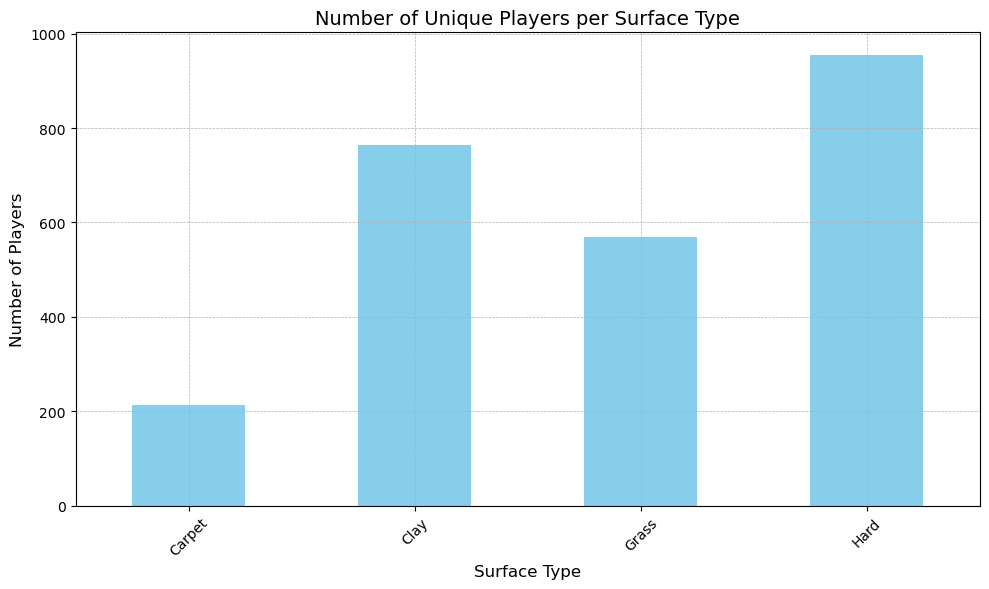

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'betting_data_dfs_preprocessed' is your main DataFrame

# Create a DataFrame with 'Surface' and players from both 'Winner' and 'Loser' for each match
surface_players = pd.DataFrame({
    'Surface': pd.concat([betting_data_dfs_preprocessed['Surface']] * 2, ignore_index=True),
    'Player': pd.concat([betting_data_dfs_preprocessed['Winner'], betting_data_dfs_preprocessed['Loser']], ignore_index=True)
})

# Group by 'Surface' and count unique 'Player' IDs
players_per_surface = surface_players.groupby('Surface')['Player'].nunique()

# Plotting the data
plt.figure(figsize=(10, 6))
players_per_surface.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Number of Unique Players per Surface Type', fontsize=14)
plt.xlabel('Surface Type', fontsize=12)
plt.ylabel('Number of Players', fontsize=12)
plt.xticks(rotation=45)  # Rotate surface names for better visibility
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [19]:
import numpy as np

# Define the range of factor values for each surface
factor_values = np.arange(0.8, 1.2, 0.1)

# Generate all combinations of surface factors
from itertools import product
surface_combinations = list(product(factor_values, repeat=4))  # Assuming three surfaces: clay, grass, hard

# Convert combinations to a list of dictionaries
surface_factor_configs = [
    {'Clay': factors[0], 'Grass': factors[1], 'Hard': factors[2], 'Carpet': factors[3]}
    for factors in surface_combinations
]

In [20]:
for config in surface_factor_configs[:10]:  # Printing only the first 10 for brevity
    print(config)

{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.8, 'Carpet': 0.8}
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.8, 'Carpet': 0.9}
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.8, 'Carpet': 1.0}
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.8, 'Carpet': 1.1}
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.9, 'Carpet': 0.8}
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.9, 'Carpet': 0.9}
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.9, 'Carpet': 1.0}
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.9, 'Carpet': 1.1}
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 1.0, 'Carpet': 0.8}
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 1.0, 'Carpet': 0.9}


In [21]:
results = []

for surface_factors in surface_factor_configs:
    for k in range(20, 21):
        elo_scores_constant_k = {}
        betting_data_copy = betting_data_dfs_preprocessed.copy()
        print(surface_factors)
        calculate_elo_with_k_and_surface(betting_data_copy, k, surface_factors)

        # Filter and evaluate as previously described
        betting_data_dfs_preprocessed_validation = betting_data_copy[betting_data_copy.Date > '2018-12-31']
        betting_data_dfs_preprocessed_validation["match_outcome"] = betting_data_dfs_preprocessed_validation["match_outcome"].astype(int)

        # Evaluate predictions
        accuracy1, calibration1, log_loss1 = evaluate_predictions(
            betting_data_dfs_preprocessed_validation["higher_rank_won"],
            betting_data_dfs_preprocessed_validation["match_outcome"], 
            betting_data_dfs_preprocessed_validation['prob_high_ranked']
        )

        # Store results
        results.append((surface_factors, k, accuracy1, calibration1, log_loss1))
    print("----------------------------------------")


{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.8, 'Carpet': 0.8}
----------------------------------------
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.8, 'Carpet': 0.9}
----------------------------------------
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.8, 'Carpet': 1.0}
----------------------------------------
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.8, 'Carpet': 1.1}
----------------------------------------
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.9, 'Carpet': 0.8}
----------------------------------------
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.9, 'Carpet': 0.9}
----------------------------------------
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.9, 'Carpet': 1.0}
----------------------------------------
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.9, 'Carpet': 1.1}
----------------------------------------
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 1.0, 'Carpet': 0.8}
----------------------------------------
{'Clay': 0.8, 'Grass': 0.8, 'Hard': 1.0, 'Carpet': 0.9}
----------------------------------------
{'Clay': 0.8, 'Grass': 0.8, 'H

In [22]:
results

[({'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.8, 'Carpet': 0.8},
  20,
  0.6278,
  0.9614,
  0.6347),
 ({'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.8, 'Carpet': 0.9},
  20,
  0.6278,
  0.9614,
  0.6347),
 ({'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.8, 'Carpet': 1.0},
  20,
  0.6278,
  0.9614,
  0.6347),
 ({'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.8, 'Carpet': 1.1},
  20,
  0.6278,
  0.9614,
  0.6347),
 ({'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.9, 'Carpet': 0.8},
  20,
  0.6313,
  0.9654,
  0.6342),
 ({'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.9, 'Carpet': 0.9},
  20,
  0.6313,
  0.9654,
  0.6342),
 ({'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.9, 'Carpet': 1.0},
  20,
  0.6313,
  0.9654,
  0.6342),
 ({'Clay': 0.8, 'Grass': 0.8, 'Hard': 0.9, 'Carpet': 1.1},
  20,
  0.6313,
  0.9654,
  0.6342),
 ({'Clay': 0.8, 'Grass': 0.8, 'Hard': 1.0, 'Carpet': 0.8},
  20,
  0.6302,
  0.9688,
  0.6338),
 ({'Clay': 0.8, 'Grass': 0.8, 'Hard': 1.0, 'Carpet': 0.9},
  20,
  0.6302,
  0.9688,
  0.6338),
 ({'Clay': 0.8, 'Grass': 0.8, 'Hard': 1.

In [24]:
# Find the entry with the minimum log loss
best_result = min(results, key=lambda x: x[4])  # x[4] refers to the log_loss in each tuple

# Extracting the metrics
surface_config = best_result[0]
k_value = best_result[1]
accuracy = best_result[2]
calibration = best_result[3]
best_log_loss = best_result[4]

# Print the results
print("Best Log Loss Metrics:\n")
print(f"Surface Configuration: {surface_config}")
print(f"K Value: {k_value}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Calibration: {calibration:.4f}")
print(f"Log Loss: {best_log_loss:.4f}")

Best Log Loss Metrics:

Surface Configuration: {'Clay': 1.0, 'Grass': 1.1, 'Hard': 1.1, 'Carpet': 0.8}
K Value: 20
Accuracy: 0.6325
Calibration: 0.9778
Log Loss: 0.6330
